In [ ]:
import os, json, cv2, numpy as np, matplotlib.pyplot as plt

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F

In [ ]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [ ]:
import sys; sys.path.insert(0, '/content/drive/MyDrive/keypoints')
import utils

In [ ]:
import sys; sys.path.insert(0, '/content/drive/MyDrive/keypoints')
import engine

In [ ]:
import sys; sys.path.insert(0, '/content/drive/MyDrive/keypoints')
import train

In [ ]:
from utils import collate_fn
from engine import train_one_epoch, evaluate

In [ ]:
import json
import os
import cv2
import matplotlib.pyplot as plt

In [ ]:
keypoint_names = ['Negative', 'Positive']

# Dictionary to convert rectangles classes into keypoint classes because keypoint classes should start with 0
rectangles2keypoints = {1:0, 2:1}

def converter(file_labels, file_image, keypoint_names):

    img = cv2.imread(file_image)
    img_w, img_h = img.shape[1], img.shape[0]

    with open(file_labels) as f:
        lines_txt = f.readlines()
        lines = []
        for line in lines_txt:
            lines.append([int(line.split()[0])] + [round(float(el), 5) for el in line.split()[1:]])

    bboxes = []
    keypoints = []

    # In this loop we convert normalized coordinates to absolute coordinates
    for line in lines:
        # Number 0 is a class of rectangles related to bounding boxes.
        if not line[0] in [0, 1]:
            x_c, y_c, w, h = round(line[1] * img_w), round(line[2] * img_h), round(line[3] * img_w), round(line[4] * img_h)
            bboxes.append([round(x_c - w/2), round(y_c - h/2), round(x_c + w/2), round(y_c + h/2)])

        # Other numbers are the classes of rectangles related to keypoints.
        # After convertion, numbers of keypoint classes should start with 0, so we apply rectangles2keypoints dictionary to achieve that.
        # In our case:
        # 1 is rectangle for negative keypoint, which is 0, so we convert 1 to 0;
        # 2 is rectangle for positive keypoint, which is 1, so we convert 2 to 1.
        else:
            kp_id, x_c, y_c = line[0], round(line[1] * img_w), round(line[2] * img_h)
            keypoints.append([kp_id, x_c, y_c])

    # In this loop we are iterating over each keypoint and looking to which bounding box it matches.
    # Thus, we are matching keypoints and corresponding bounding boxes.
    keypoints_sorted = [[[] for _ in keypoint_names] for _ in bboxes]
    for kp in keypoints:
        kp_id, kp_x, kp_y = kp[0], kp[1], kp[2]
        for bbox_idx, bbox in enumerate(bboxes):
            x1, y1, x2, y2 = bbox[0], bbox[1], bbox[2], bbox[3]
            if x1 < kp_x < x2 and y1 < kp_y < y2:
                keypoints_sorted[bbox_idx][kp_id] = [kp_x, kp_y, 1] # All keypoints are visible

    return bboxes, keypoints_sorted

In [ ]:
def dump2json(bboxes, keypoints_sorted, file_json):
    annotations = {}
    annotations['bboxes'], annotations['keypoints'] = bboxes, keypoints_sorted
    with open(file_json, "w") as f:
        json.dump(annotations, f)

In [ ]:
IMAGES = '/content/drive/MyDrive/PI/Diode/train/images'
LABELS = '/content/drive/MyDrive/PI/Diode/train/labels'
ANNOTATIONS = '/content/drive/MyDrive/PI/Diode/train/annotations'

files_names = [file.split('.jpg')[0] for file in os.listdir(IMAGES)]

for file in files_names:
    file_labels = os.path.join(LABELS, file + ".txt")
    file_image = os.path.join(IMAGES, file + ".jpg")
    bboxes, keypoints_sorted = converter(file_labels, file_image, keypoint_names)
    dump2json(bboxes, keypoints_sorted, os.path.join(ANNOTATIONS, file + '.json'))

In [ ]:
IMAGES = '/content/drive/MyDrive/PI/Diode/test/images'
LABELS = '/content/drive/MyDrive/PI/Diode/test/labels'
ANNOTATIONS = '/content/drive/MyDrive/PI/Diode/test/annotations'

files_names = [file.split('.jpg')[0] for file in os.listdir(IMAGES)]

for file in files_names:
    file_labels = os.path.join(LABELS, file + ".txt")
    file_image = os.path.join(IMAGES, file + ".jpg")
    bboxes, keypoints_sorted = converter(file_labels, file_image, keypoint_names)
    dump2json(bboxes, keypoints_sorted, os.path.join(ANNOTATIONS, file + '.json'))

In [ ]:
class ClassDataset(Dataset):
    def __init__(self, root, transform=None, demo=False):
        self.root = root
        self.transform = transform
        self.demo = demo # Use demo=True if you need transformed and original images (for example, for visualization purposes)
        self.imgs_files = sorted(os.listdir(os.path.join(root, "images")))
        self.annotations_files = sorted(os.listdir(os.path.join(root, "annotations")))
        print (len (self.imgs_files), len (self.annotations_files))

    def __getitem__(self, idx):
        print (self.imgs_files[idx])
        img_path = os.path.join(self.root, "images", self.imgs_files[idx])
        annotations_path = os.path.join(self.root, "annotations", self.annotations_files[idx])

        img_original = cv2.imread(img_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

        with open(annotations_path) as f:
            data = json.load(f)
            bboxes_original = data['bboxes']
            keypoints_original = data['keypoints']

            # All objects diode binarized images
            bboxes_labels_original = ['Diode' for _ in bboxes_original]

            '''        if self.transform:
            # Converting keypoints from [x,y,visibility]-format to [x, y]-format + Flattening nested list of keypoints
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]], where each keypoint is in [x, y]-format
            # Then we need to convert it to the following list:
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2]
            keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]

            # Apply augmentations
            #transformed = self.transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
            #img = transformed['image']
            bboxes = transformed['bboxes']

            # Unflattening list transformed['keypoints']
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2], where each keypoint is in [x, y]-format
            # Then we need to convert it to the following list:
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]]
            keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,2,2)).tolist()

            # Converting transformed keypoints from [x, y]-format to [x,y,visibility]-format by appending original visibilities to transformed coordinates of keypoints
            keypoints = []
            for o_idx, obj in enumerate(keypoints_transformed_unflattened): # Iterating over objects
                obj_keypoints = []
                for k_idx, kp in enumerate(obj): # Iterating over keypoints in each object
                    # kp - coordinates of keypoint
                    # keypoints_original[o_idx][k_idx][2] - original visibility of keypoint
                    obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints)

        else:'''
        img, bboxes, keypoints = img_original, bboxes_original, keypoints_original
        # print (keypoints)
        # Convert everything into a torch tensor
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)
        target = {}
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor([1 for _ in bboxes], dtype=torch.int64) # all objects are glue tubes
        target["image_id"] = torch.tensor([idx])
        target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
        target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)
        img = F.to_tensor(img)

        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original["boxes"] = bboxes_original
        target_original["labels"] = torch.as_tensor([1 for _ in bboxes_original], dtype=torch.int64) # all objects are glue tubes
        target_original["image_id"] = torch.tensor([idx])
        target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)
        img_original = F.to_tensor(img_original)

        if self.demo:
            return img, target, img_original, target_original
        else:
            return img, target

    def __len__(self):
        return len(self.imgs_files)

In [ ]:
KEYPOINTS_FOLDER_TEST = '/content/drive/MyDrive/PI/Diode/test'
dataset = ClassDataset(KEYPOINTS_FOLDER_TEST)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)

print("Original targets:\n", batch[1], "\n\n")

58 58
D28_jpg.rf.5c985106decac5249e87288edd412a79.var6.jpg
Original targets:
 ({'boxes': tensor([[298.,  90., 476., 382.]]), 'labels': tensor([1]), 'image_id': tensor([34]), 'area': tensor([51976.]), 'iscrowd': tensor([0]), 'keypoints': tensor([[[373., 243.,   1.],
         [459., 315.,   1.]]])},) 




((tensor([[[0.0078, 0.0078, 0.0039,  ..., 0.0118, 0.0078, 0.0000],
         [0.0157, 0.0157, 0.0157,  ..., 0.0235, 0.0118, 0.0000],
         [0.0157, 0.0157, 0.0157,  ..., 0.0314, 0.0157, 0.0000],
         ...,
         [0.0078, 0.0118, 0.0157,  ..., 0.0118, 0.0078, 0.0078],
         [0.0078, 0.0118, 0.0157,  ..., 0.0078, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0039,  ..., 0.0039, 0.0039, 0.0000]],

        [[0.0078, 0.0078, 0.0039,  ..., 0.0118, 0.0078, 0.0000],
         [0.0157, 0.0157, 0.0157,  ..., 0.0235, 0.0118, 0.0000],
         [0.0157, 0.0157, 0.0157,  ..., 0.0314, 0.0157, 0.0000],
         ...,
         [0.0078, 0.0118, 0.0157,  ..., 0.0118, 0.0078, 0.0078],
         [0.0078, 0.0118, 0.0157,  ..., 0.0078, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0039,  ..., 0.0039, 0.0039, 0.0000]],

        [[0.0078, 0.0078, 0.0039,  ..., 0.0118, 0.0078, 0.0000],
         [0.0157, 0.0157, 0.0157,  ..., 0.0235, 0.0118, 0.0000],
         [0.0157, 0.0157, 0.0157,  ..., 0.0314, 0.0157, 

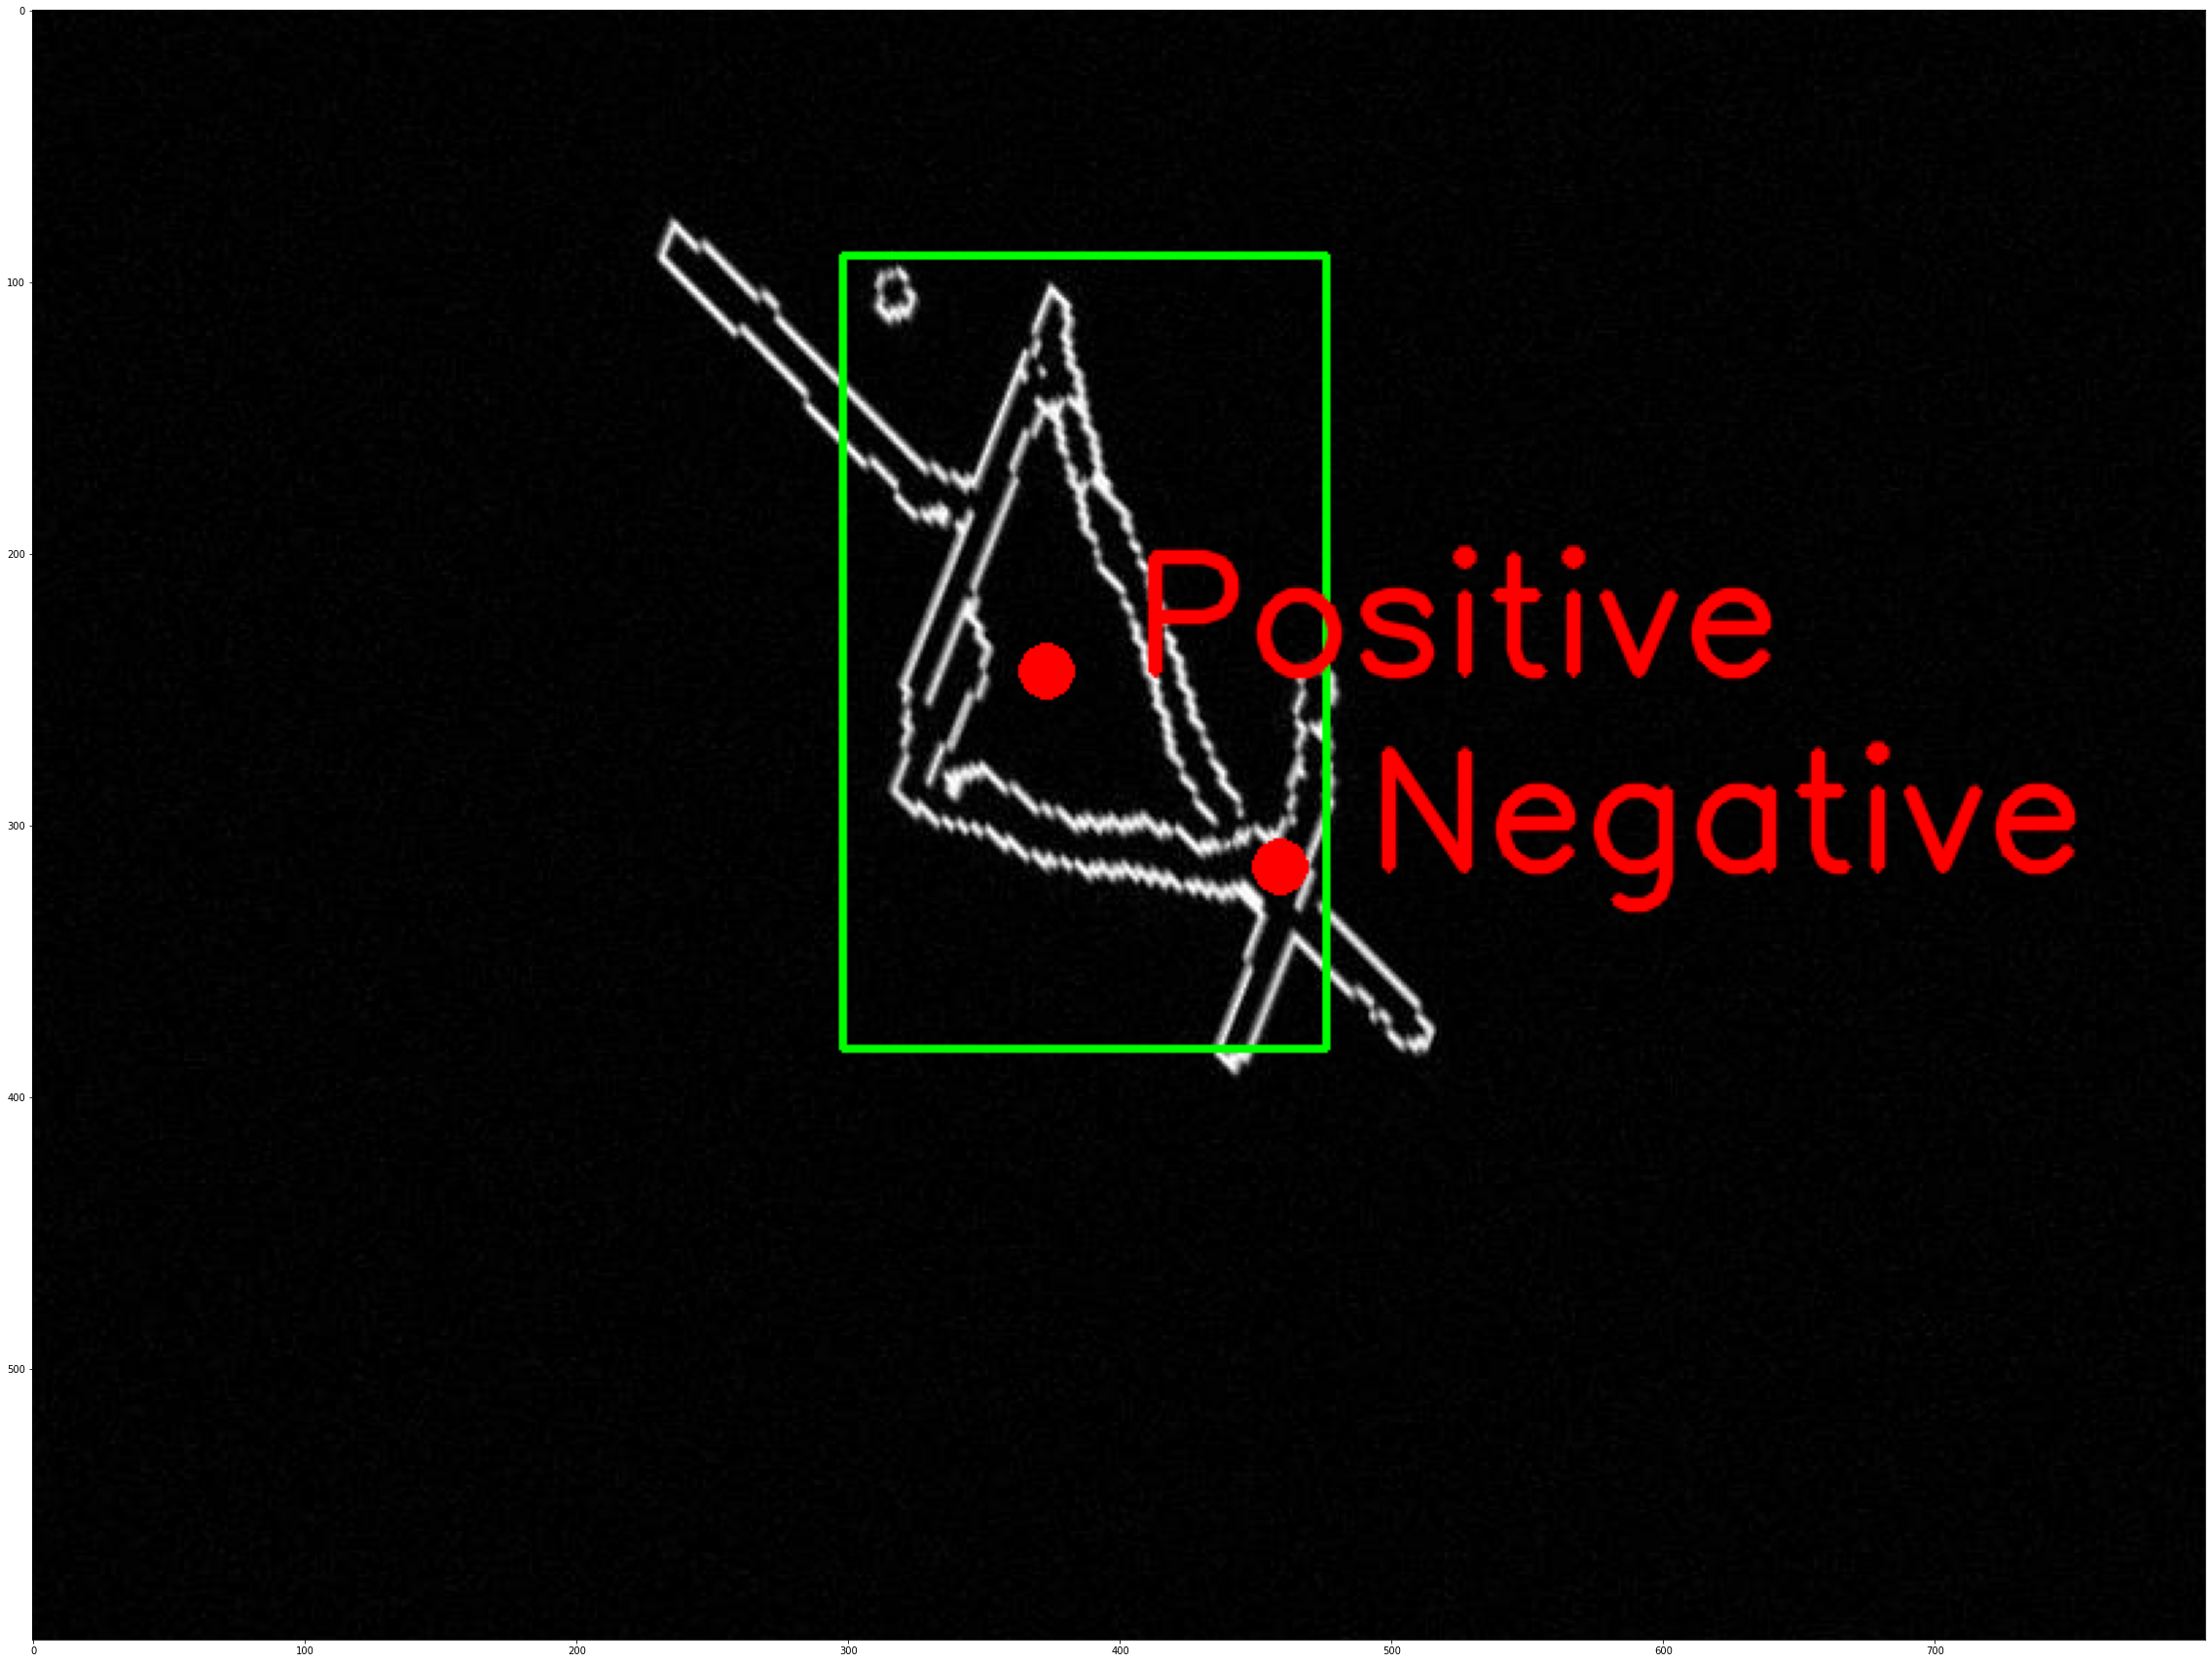

In [ ]:
keypoints_classes_ids2names = {0: 'Positive', 1: 'Negative'}

def visualize(image, bboxes, keypoints, bboxes_original = None, keypoints_original = None, image_original = None):
    fontsize = 18

    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)

    for kps in keypoints:
        for idx, kp in enumerate(kps):
            image = cv2.circle(image.copy(), tuple(kp), 5, (255,0,0), 10)
            image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)


    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)

        for kps in keypoints_original:
            for idx, kp in enumerate(kps):
                image_original = cv2.circle(image_original, tuple(kp), 5, (255,0,0), 10)
                image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)

image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
print (batch)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

# image_original = (batch[1][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp[:2] for kp in kps])

# visualize(image, bboxes, keypoints, bboxes_original, keypoints_original)
visualize(image, bboxes, keypoints)

In [ ]:
def get_model(num_keypoints, weights_path=None):

    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=num_keypoints,
                                                                   num_classes = 2, # Background is the first class, object is the second class
                                                                   rpn_anchor_generator=anchor_generator)

    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)

    return model

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

KEYPOINTS_FOLDER_TRAIN = '/content/drive/MyDrive/PI/Diode/train'
KEYPOINTS_FOLDER_TEST = '/content/drive/MyDrive/PI/Diode/test'

dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, demo=False)
dataset_test = ClassDataset(KEYPOINTS_FOLDER_TEST, demo=False)

data_loader_train = DataLoader(dataset_train, batch_size=3, shuffle=True, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

model = get_model(num_keypoints = 2)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)
num_epochs = 50

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=1000)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device)

# Save model weights after training
torch.save(model.state_dict(), '/content/drive/MyDrive/PI/Diode/weights/keypointsrcnn_weights.pth')

198 198
42 42


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and will be removed in 0.15, please use 'weights_backbone' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight

A saída de streaming foi truncada nas últimas 5000 linhas.
D34_jpg.rf.713395226aca9ba37afdea73c6dc4600.var1.jpg
D6_jpg.rf.1b14c054c0f54e9c6d463104aaaad7bf.var7.jpg
D31_jpg.rf.bb1e338023ec067a9d9a4efe5b850630.var1.jpg
D8_jpg.rf.1c84d3e3bbbd13fe4aea6631b0293bae.var5.jpg
D4_jpg.rf.510aee4f48c8d5c7350f99f57ed5e3c1.var8.jpg
D32_jpg.rf.948124af6fb68e48f3b13f1d380a9620.var1.jpg
D49_jpg.rf.0e28b02dc1f42d49c9984faf72c2a87a.var8.jpg
D23_jpg.rf.bde09cd39fc7005b092d6768e859e6e6.var5.jpg
D46_jpg.rf.f375d8290745a9203e3e5985876baf7f.var7.jpg
D49_jpg.rf.0e28b02dc1f42d49c9984faf72c2a87a.var9.jpg
D32_jpg.rf.948124af6fb68e48f3b13f1d380a9620.var4.jpg
D8_jpg.rf.1c84d3e3bbbd13fe4aea6631b0293bae.var6.jpg
D4_jpg.rf.510aee4f48c8d5c7350f99f57ed5e3c1.var5.jpg
D44_jpg.rf.e3e843b2c4c04b6575172c927ec2e9f5.var7.jpg
D5_jpg.rf.2cfc4f8a34cbe1715a6dde66941e69da.var2.jpg
D8_jpg.rf.1c84d3e3bbbd13fe4aea6631b0293bae.var4.jpg
D18_jpg.rf.c955d136b7b779bc19f5181e826f82c5.var3.jpg
D15_jpg.rf.173ae0cdfbcc5f4dad4a5be5ceb41e67.var

In [ ]:
iterator = iter(data_loader_test)
images, targets = next(iterator)
images = list(image.to(device) for image in images)

with torch.no_grad():
    model.to(device)
    model.eval()
    output = model(images)

print("Predictions: \n", output)

D12_jpg.rf.ae1ad9144466c5901d5c60f02f586108.var2.jpg
Predictions: 
 [{'boxes': tensor([[173.1369, 118.0342, 594.7754, 541.5402],
        [ 19.4566, 220.5225, 618.3842, 427.5447],
        [157.0268, 138.8795, 722.1440, 389.7036],
        [181.3339, 123.9212, 387.1798, 600.0000],
        [379.1167, 144.7561, 576.0167, 452.6180],
        [ 76.8349, 251.1186, 463.8737, 541.9437],
        [355.9077, 109.2472, 717.1896, 480.2039],
        [475.2592, 125.1098, 787.7488, 412.8674],
        [231.6479, 266.4900, 397.5967, 577.7345],
        [  6.5252, 179.3038, 387.9726, 498.9787],
        [187.2445, 174.3178, 319.7212, 534.8304]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9638, 0.8002, 0.7190, 0.4398, 0.3539, 0.3007, 0.2331, 0.1109, 0.0873,
        0.0663, 0.0630], device='cuda:0'), 'keypoints': tensor([[[376.8288, 338.7820,   1.0000],
         [572.6431, 292.3088,   1.0000]],

        [[390.8817, 334.4968,   1.0000],
         [5

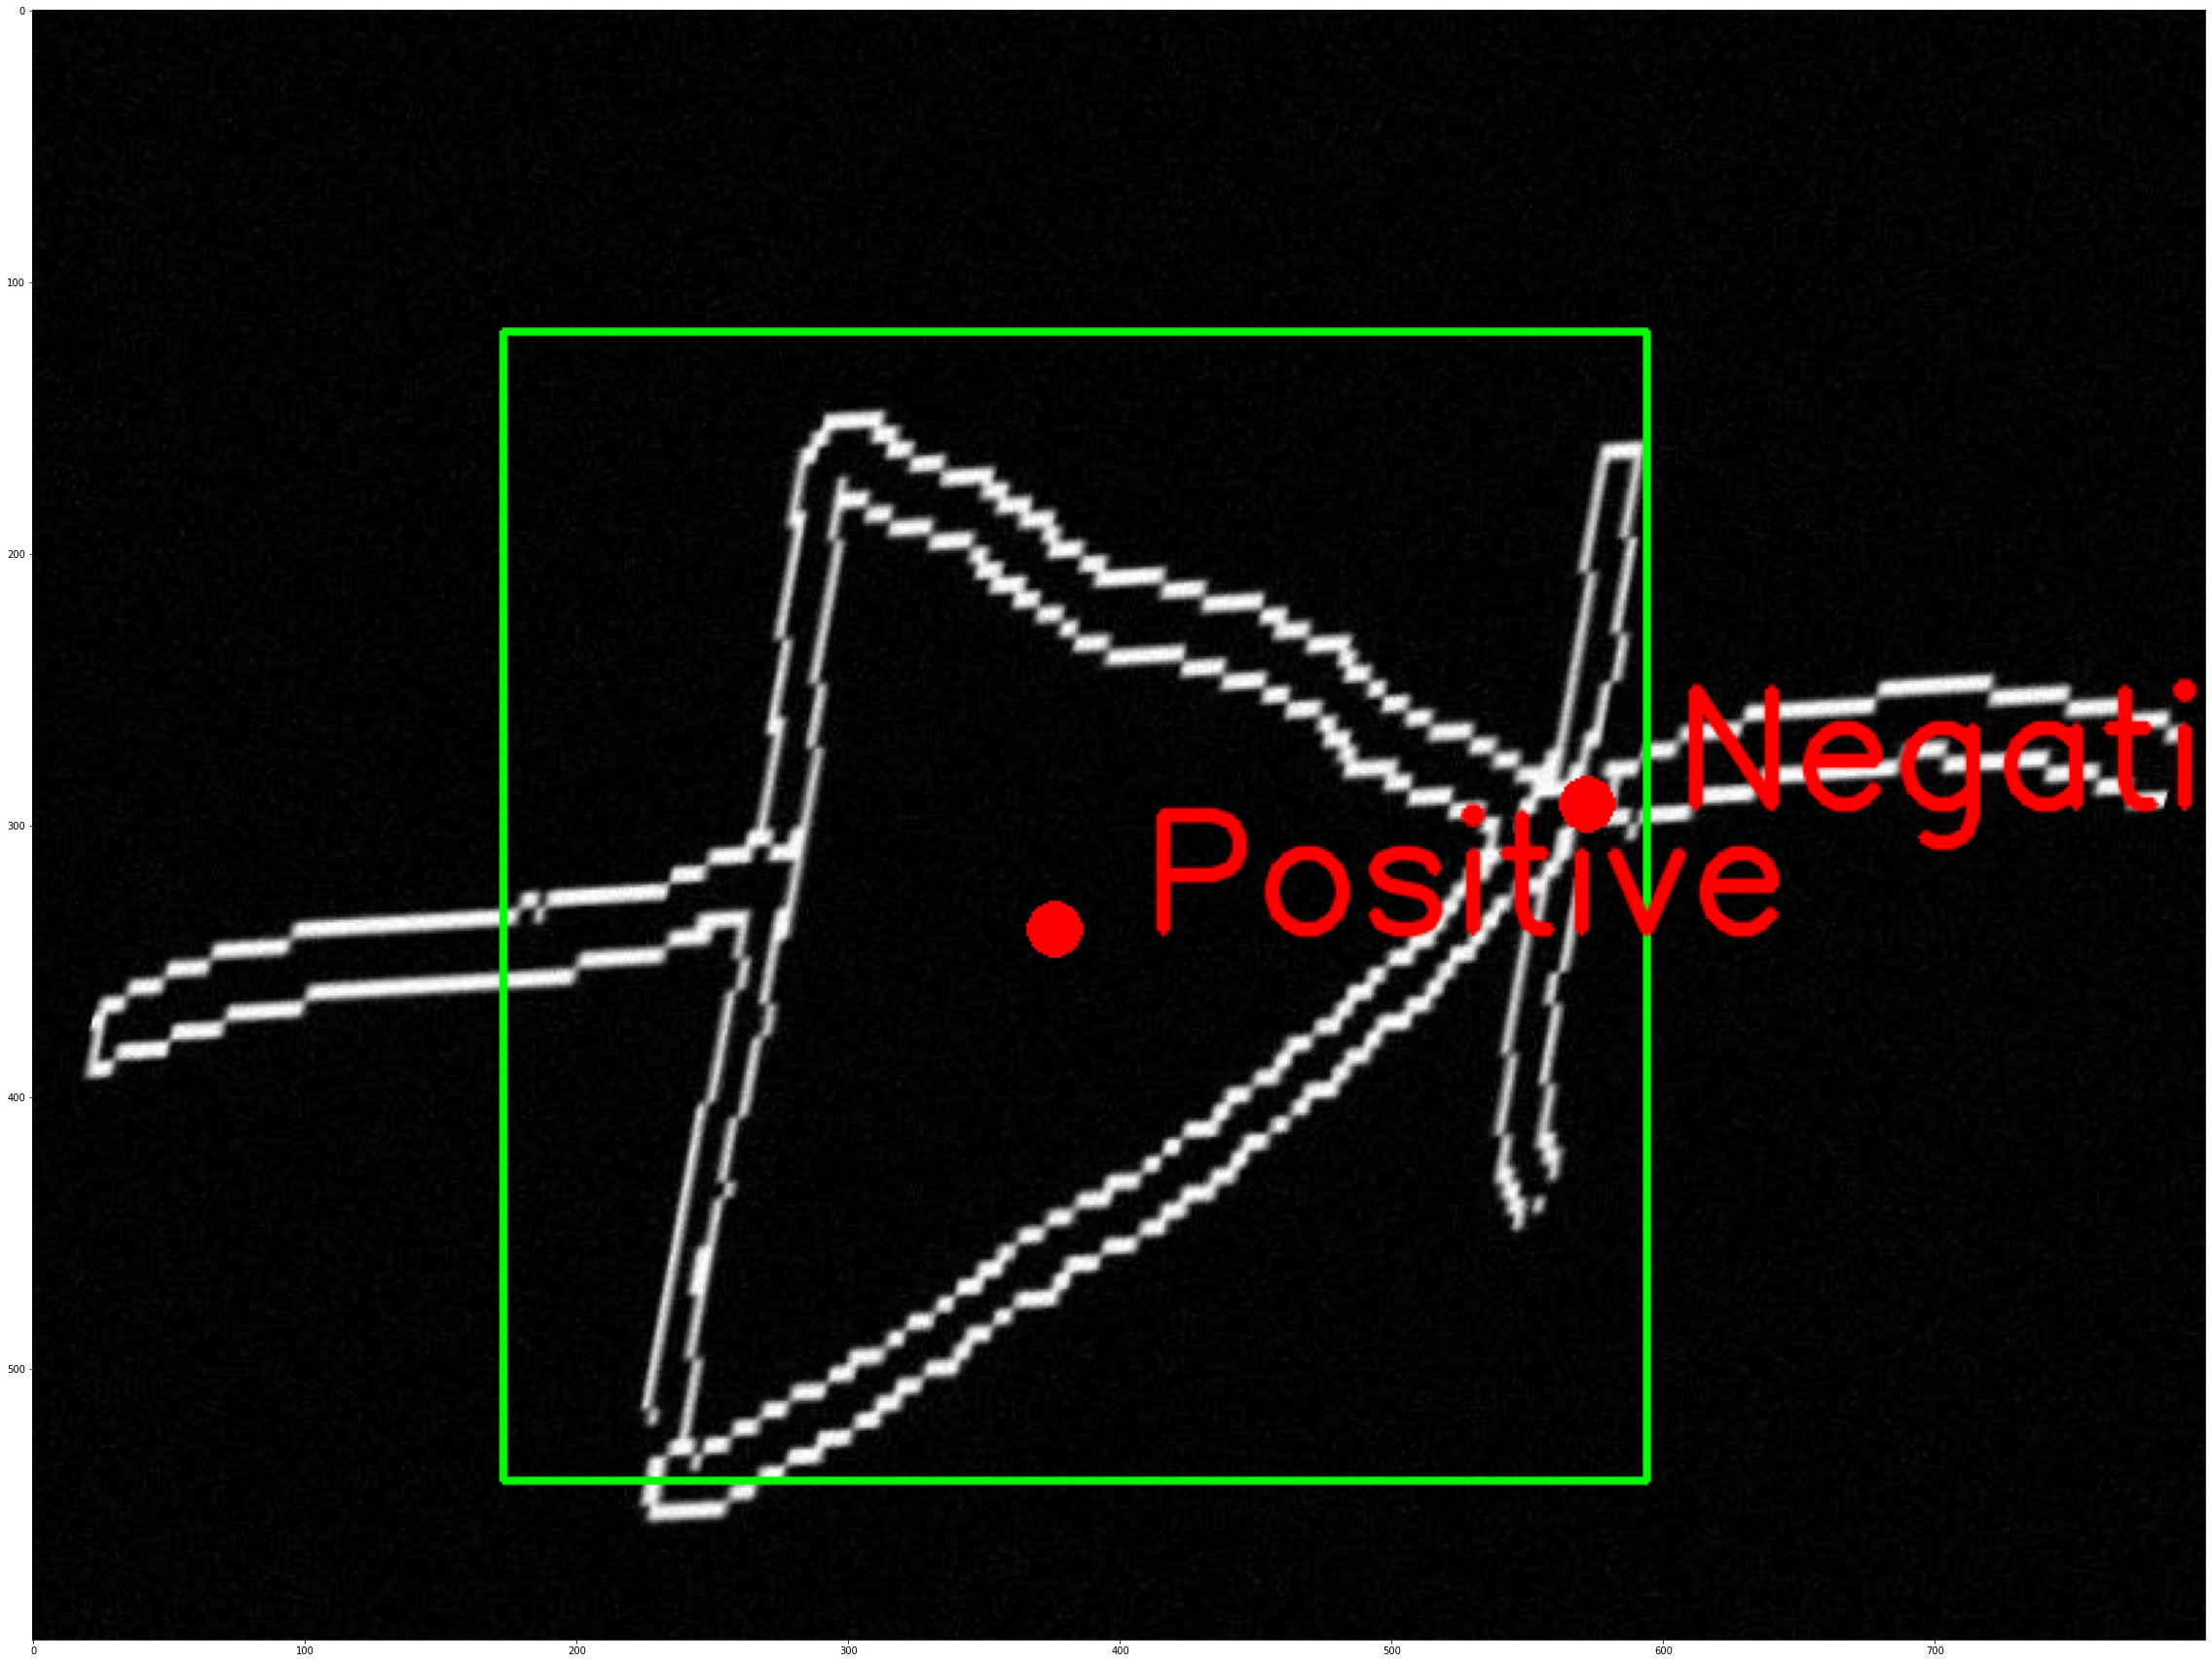

In [ ]:
image = (images[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
scores = output[0]['scores'].detach().cpu().numpy()

high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

keypoints = []
for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])

bboxes = []
for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))

visualize(image, bboxes, keypoints)